In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade ultralytics --no-deps
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="vM6qrOEJgCQAXNdbbGk0")

# Correct workspace and project from your link
project = rf.workspace("objectdetection-tecsf").project("skysealand-wrqjn")

# Load version (change version number if you need)
version = project.version(2)

# Download dataset in valid format
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 41.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 96.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 


Extracting Dataset Version Zip to Skysealand-2 in yolov11:: 100%|██████████| 2626/2626 [00:00<00:00, 3934.08it/s]


In [3]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import os

print(os.listdir("/kaggle/working"))


['Skysealand-2', '.virtual_documents']


In [5]:
for item in os.listdir("/kaggle/working"):
    print(item)


Skysealand-2
.virtual_documents


In [6]:
import os

base = "/kaggle/working"
dataset_dir = [d for d in os.listdir(base) if d.lower().startswith("sky")][0]

print("Dataset folder:", dataset_dir)

yaml_path = f"{base}/{dataset_dir}/data.yaml"

yaml_content = f"""
train: {base}/{dataset_dir}/train/images
val: {base}/{dataset_dir}/valid/images
test: {base}/{dataset_dir}/test/images

nc: 4
names:
  - Airplane
  - Boat
  - Car
  - Ship
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("Data.yaml written to:", yaml_path)


Dataset folder: Skysealand-2
Data.yaml written to: /kaggle/working/Skysealand-2/data.yaml


In [7]:
print(os.listdir(f"/kaggle/working/{dataset_dir}"))


['test', 'data.yaml', 'valid', 'train', 'README.roboflow.txt', 'README.dataset.txt']


In [8]:
for root, dirs, files in os.walk("/kaggle/working"):
    if "data.yaml" in files:
        print(os.path.join(root, "data.yaml"))


/kaggle/working/Skysealand-2/data.yaml


In [9]:
import os, shutil

base_path = "/kaggle/working/Surgical-Tools-1"

for folder in ['train', 'valid', 'test']:
    img_dir = os.path.join(base_path, folder, 'images')
    label_dir = os.path.join(base_path, folder, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

# move misplaced images from root into train/images if any
for f in os.listdir(base_path):
    if f.endswith('.jpg') or f.endswith('.png'):
        shutil.move(os.path.join(base_path, f), os.path.join(base_path, 'train/images', f))

print("Folder structure ready for YOLO training.")

Folder structure ready for YOLO training.


In [10]:
import os
os.listdir("/kaggle/working")


['Skysealand-2', '.virtual_documents', 'Surgical-Tools-1']

In [11]:
from ultralytics import YOLO
from pathlib import Path
import os

# Auto-detect SkySeaLand dataset folder
base = "/kaggle/working"
dataset_dir = [d for d in os.listdir(base) if "sky" in d.lower()][0]

DATA = f"{base}/{dataset_dir}/data.yaml"
OUTPUT_FOLDER = Path("/kaggle/working/yolo-output")

# Check YAML exists before training
if not Path(DATA).exists():
    raise FileNotFoundError(f"data.yaml not found at: {DATA}")

print("Using dataset:", DATA)

# Correct model name (YOLOv8)
model = YOLO("yolov8n.pt")

# Train model
model.train(
    data=DATA,
    epochs=50,
    imgsz=640,
    batch=16,
    workers=2,
    project=str(OUTPUT_FOLDER),
    name="train"
)

print("Training started successfully!")


Using dataset: /kaggle/working/Skysealand-2/data.yaml
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Skysealand-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

invalid value encountered in less
invalid value encountered in less


                   all        132       1992      0.848      0.762      0.819      0.511
              Airplane         37        367      0.953      0.879      0.931      0.548
                  Boat         33        657      0.805      0.738      0.793      0.491
                   Car         31        679      0.863       0.76      0.815      0.528
                  Ship         52        289      0.771      0.671      0.737       0.48
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /kaggle/working/yolo-output/train
Training started successfully!


In [12]:
metrics = model.val(
    data=str(DATA),      
    split="test",        
    plots=True,           
    project=str(OUTPUT_FOLDER),  
    name="val"           
)


print(" Test set evaluation results:")
print("Precision   :", metrics.box.mp)      
print("Recall      :", metrics.box.mr)     
print("mAP@0.5     :", metrics.box.map50)   
print("mAP@[.5:.95]:", metrics.box.map)

Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2983.9±551.8 MB/s, size: 250.4 KB)
val: Scanning /kaggle/working/Skysealand-2/test/labels... 127 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 127/127 1.4Kit/s 0.1s
val: New cache created: /kaggle/working/Skysealand-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.8it/s 2.8s0.2s


invalid value encountered in less
invalid value encountered in less


                   all        127       2075      0.839      0.755      0.833      0.496
              Airplane         52        553      0.944      0.917      0.949      0.534
                  Boat         23        334      0.754      0.719      0.781      0.478
                   Car         24        798      0.834      0.742      0.832      0.508
                  Ship         46        390      0.825      0.641      0.772      0.463
Speed: 1.4ms preprocess, 12.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /kaggle/working/yolo-output/val
 Test set evaluation results:
Precision   : 0.8391145208482632
Recall      : 0.7545107371853049
mAP@0.5     : 0.833237853207154
mAP@[.5:.95]: 0.4955791160295561


In [13]:
from ultralytics import YOLO
from pathlib import Path

# --- 1. Define Paths ---
# Ensure these paths match your training setup
DATA = "/kaggle/working/Skysealand-2/data.yaml"
OUTPUT_FOLDER = Path("/kaggle/working/yolo-output")
# This assumes your training run was named "train" (from project=OUTPUT_FOLDER, name="train")
# If you used a different name, change "train" here.
TRAIN_RUN_PATH = OUTPUT_FOLDER / "train" 
BEST_WEIGHTS_PATH = TRAIN_RUN_PATH / "weights" / "best.pt"

# --- 2. Load the Best Model ---
# Load the best model weights saved during training
print(f"Loading best model from: {BEST_WEIGHTS_PATH}")
model = YOLO(BEST_WEIGHTS_PATH)

# --- 3. Evaluate on the Test Set ---
print("Evaluating model on the 'test' split...")
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,                 # Save confusion matrix, P-R curve, etc.
    project=str(OUTPUT_FOLDER),
    name="test_evaluation"      # Saves results to /kaggle/working/yolo-output/test_evaluation
)

# --- 4. Extract, Calculate, and Print Metrics ---
print("Extracting metrics...")
map50_95 = metrics.box.map    # mAP@0.5:0.95
map50 = metrics.box.map50     # mAP@0.5
precision = metrics.box.mp    # Precision
recall = metrics.box.mr       # Recall

# Calculate F1 Score
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6) # Add 1e-6 to avoid division by zero

# Print the results in a clean format
print("\n--- Test Set Evaluation Results ---")
print(f"Model: {str(BEST_WEIGHTS_PATH)}")
print(f"mAP@0.5:0.95: {map50_95:.4f}")
print(f"mAP@0.5       : {map50:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print("-----------------------------------")

Loading best model from: /kaggle/working/yolo-output/train/weights/best.pt
Evaluating model on the 'test' split...
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2974.0±1441.7 MB/s, size: 161.1 KB)
val: Scanning /kaggle/working/Skysealand-2/test/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 127/127 280.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.6it/s 3.0s0.2s


invalid value encountered in less
invalid value encountered in less


                   all        127       2075      0.839      0.755      0.833      0.496
              Airplane         52        553      0.944      0.917      0.949      0.534
                  Boat         23        334      0.754      0.719      0.781      0.478
                   Car         24        798      0.834      0.742      0.832      0.508
                  Ship         46        390      0.825      0.641      0.772      0.463
Speed: 1.4ms preprocess, 2.8ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /kaggle/working/yolo-output/test_evaluation
Extracting metrics...

--- Test Set Evaluation Results ---
Model: /kaggle/working/yolo-output/train/weights/best.pt
mAP@0.5:0.95: 0.4956
mAP@0.5       : 0.8332
Precision     : 0.8391
Recall        : 0.7545
F1 Score      : 0.7946
-----------------------------------


In [14]:
!pip install ttach

In [15]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 168 (delta 39), reused 21 (delta 11), pack-reused 99 (from 2)
Receiving objects: 100% (168/168), 52.67 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [16]:
!ls /kaggle/working/YOLO-V8-CAM

images	     models	test	  YOLO_v11_EigenCAM.ipynb
LICENSE.txt  README.md	yolo_cam  YOLO_v8n_EigenCAM.ipynb


In [17]:
import sys
sys.path.append("/kaggle/working/YOLO-V8-CAM")

In [18]:
%cd /kaggle/working
!rm -rf YOLO-V8-CAM
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

/kaggle/working
Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 168 (delta 39), reused 21 (delta 11), pack-reused 99 (from 2)
Receiving objects: 100% (168/168), 52.67 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [19]:
%cd /kaggle/working/YOLO-V8-CAM
!pip install -e .

/kaggle/working/YOLO-V8-CAM
Obtaining file:///kaggle/working/YOLO-V8-CAM
ERROR: file:///kaggle/working/YOLO-V8-CAM does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [20]:
!ls /kaggle/working/YOLO-V8-CAM

images	     models	test	  YOLO_v11_EigenCAM.ipynb
LICENSE.txt  README.md	yolo_cam  YOLO_v8n_EigenCAM.ipynb


In [21]:
import os, sys

print("Checking folder exists:")
print(os.path.exists("/kaggle/working/YOLO-V8-CAM"))
print(os.path.exists("/kaggle/working/YOLO-V8-CAM/yolo_cam"))

print("\nListing YOLO-V8-CAM:")
os.system("ls /kaggle/working/YOLO-V8-CAM")

print("\nListing yolo_cam:")
os.system("ls /kaggle/working/YOLO-V8-CAM/yolo_cam")

print("\nPython path BEFORE:")
print(sys.path)

sys.path.insert(0, "/kaggle/working/YOLO-V8-CAM")

print("\nPython path AFTER:")
print(sys.path)

try:
    import yolo_cam
    print("✅ yolo_cam imported")
except Exception as e:
    print("❌ IMPORT FAILED:", e)


Checking folder exists:
True
True

Listing YOLO-V8-CAM:
images
LICENSE.txt
models
README.md
test
yolo_cam
YOLO_v11_EigenCAM.ipynb
YOLO_v8n_EigenCAM.ipynb

Listing yolo_cam:
activations_and_gradients.py
base_cam.py
eigen_cam.py
__init__.py
utils

Python path BEFORE:
['/usr/local/lib/python3.11/dist-packages/ray/thirdparty_files', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/tmp/tmp7ta1rbux', '/kaggle/working/YOLO-V8-CAM']

Python path AFTER:
['/kaggle/working/YOLO-V8-CAM', '/usr/local/lib/python3.11/dist-packages/ray/thirdparty_files', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dyn

In [22]:
import importlib.util
import sys

module_path = "/kaggle/working/YOLO-V8-CAM/yolo_cam/__init__.py"

spec = importlib.util.spec_from_file_location("yolo_cam", module_path)
yolo_cam = importlib.util.module_from_spec(spec)
sys.modules["yolo_cam"] = yolo_cam
spec.loader.exec_module(yolo_cam)

# Now load EigenCAM directly
spec2 = importlib.util.spec_from_file_location(
    "yolo_cam.eigen_cam",
    "/kaggle/working/YOLO-V8-CAM/yolo_cam/eigen_cam.py"
)
eigen_cam = importlib.util.module_from_spec(spec2)
sys.modules["yolo_cam.eigen_cam"] = eigen_cam
spec2.loader.exec_module(eigen_cam)

EigenCAM = eigen_cam.EigenCAM

print("✅ EigenCAM manually loaded")


✅ EigenCAM manually loaded


In [23]:
import sys
sys.path = ["/kaggle/working/YOLO-V8-CAM"] + sys.path

In [24]:
from yolo_cam.eigen_cam import EigenCAM

Running EigenCAM on: sample_01138_jpg.rf.e416fb71c2ce54332ad9959185a4202e.jpg


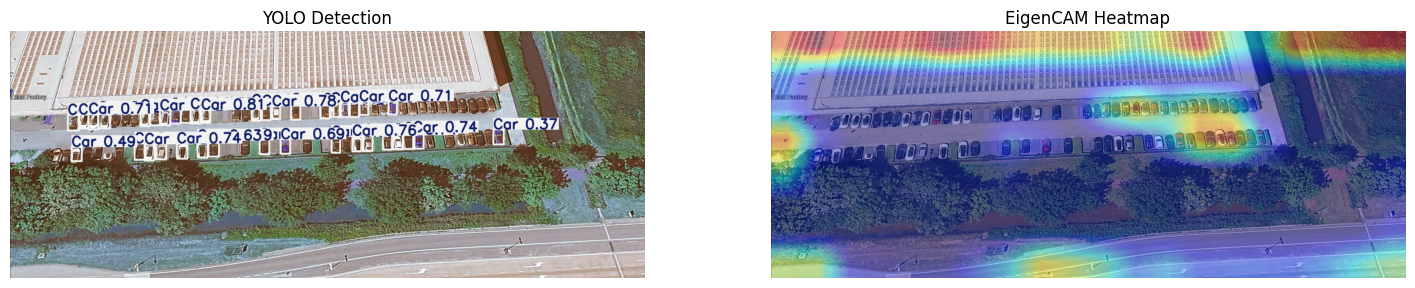

In [25]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Load trained model ---
BEST_WEIGHTS_PATH = "/kaggle/working/yolo-output/train/weights/best.pt"
model = YOLO(BEST_WEIGHTS_PATH)

# --- Choose CAM Layer ---
target_layer = model.model.model[-2]   # best deep layer for YOLOv8 CAM

# --- Get a random test image ---
TEST_IMG_DIR = "/kaggle/working/Skysealand-2/test/images"
images = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg','.png','.jpeg'))]

if not images:
    raise Exception("❌ No images found in test directory!")

img_name = random.choice(images)
img_path = os.path.join(TEST_IMG_DIR, img_name)

# --- Load image ---
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print("Running EigenCAM on:", img_name)

# --- Run YOLO prediction ---
results = model(img_rgb, verbose=False)

# --- Run EigenCAM ---
cam = EigenCAM(model=model, target_layers=[target_layer], task='od')
grayscale_cam = cam(img_rgb)[0]   # ✅ correct call

# --- Resize CAM ---
grayscale_cam = cv2.resize(grayscale_cam, (img_rgb.shape[1], img_rgb.shape[0]))

# --- Normalize CAM ---
cam_norm = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
heatmap = cv2.applyColorMap(np.uint8(255 * cam_norm), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# --- Overlay ---
overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

# --- Plot detections ---
det = results[0].plot()
det = cv2.cvtColor(det, cv2.COLOR_BGR2RGB)

# --- Show ---
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].imshow(det)
ax[0].set_title("YOLO Detection")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title("EigenCAM Heatmap")
ax[1].axis("off")

plt.show()


In [26]:
from yolo_cam.eigen_cam import EigenCAM

In [27]:
import yaml

DATA = "/kaggle/working/Skysealand-2/data.yaml"

with open(DATA, "r") as f:
    data_cfg = yaml.safe_load(f)

names = data_cfg["names"]          
num_classes = len(names)

print("Classes:")
for cid, cname in enumerate(names):
    print(cid, "->", cname)


Classes:
0 -> Airplane
1 -> Boat
2 -> Car
3 -> Ship


In [28]:
import os, cv2
import numpy as np
from ultralytics import YOLO

names = ["Airplane", "Boat", "Car", "Ship"]
BEST_WEIGHTS_PATH = "/kaggle/working/yolo-output/train/weights/best.pt"
TEST_IMG_DIR = "/kaggle/working/Skysealand-2/test/images"
OUT_DET_DIR = "/kaggle/working/yolo-output/test_dets"
os.makedirs(OUT_DET_DIR, exist_ok=True)

model = YOLO(BEST_WEIGHTS_PATH)

class_counts = {cid: 0 for cid in range(len(names))}

images


['sample_01052_jpg.rf.b0e7db2476c1949a7ce7e25257f09240.jpg',
 'sample_01121_jpg.rf.5a06078a417c3818bec8dbd5d681356c.jpg',
 'sample_01105_jpg.rf.0873d9f8b6531070195df81fcdc6d4a3.jpg',
 'sample_01069_jpg.rf.61f444d583dc20fc36327dadfdd86d75.jpg',
 'sample_01073_jpg.rf.df07f862961cece3aa21679e86b32744.jpg',
 'sample_01074_jpg.rf.b2f2d17d92644a60845cbf2dfe28a72c.jpg',
 'sample_01090_jpg.rf.1d4e987fc8ea8c02435cff4a5c0a6061.jpg',
 'sample_01127_jpg.rf.86ef5ad576605cd79c905b313603c16f.jpg',
 'sample_01085_jpg.rf.3f79be8d0408b00c6650f1dc6a3cff63.jpg',
 'sample_01175_jpg.rf.99f44dd56f506322999151c3df9ef194.jpg',
 'sample_01152_jpg.rf.afd0d5b8c08ce5bf51276ba887bb2630.jpg',
 'sample_01160_jpg.rf.193381b5da5e6aeb35ae5141ad96c29a.jpg',
 'sample_01061_jpg.rf.a9630d61882c53298c45510f76acfa9d.jpg',
 'sample_01161_jpg.rf.7c2ec1ae17504324bcee6579f8928d5c.jpg',
 'sample_01146_jpg.rf.07488c68dfe716705b02aaf12e9fab19.jpg',
 'sample_01139_jpg.rf.be045f2876b7edb5caff38559f0fe439.jpg',
 'sample_01070_jpg.rf.fe

In [29]:
import os, cv2
import numpy as np
from ultralytics import YOLO

names = ["Airplane", "Boat", "Car", "Ship"]
BEST_WEIGHTS_PATH = "/kaggle/working/yolo-output/train/weights/best.pt"
TEST_IMG_DIR = "/kaggle/working/Skysealand-2/test/images"
OUT_DET_DIR = "/kaggle/working/yolo-output/test_dets"
os.makedirs(OUT_DET_DIR, exist_ok=True)

model = YOLO(BEST_WEIGHTS_PATH)

class_counts = {cid: 0 for cid in range(len(names))}

images = [f for f in os.listdir(TEST_IMG_DIR)
          if f.lower().endswith((".jpg", ".jpeg", ".png"))]

for img_name in images:
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = model(img_rgb, verbose=False)
    r = results[0]

    if r.boxes is not None:
        cls_ids = r.boxes.cls.cpu().numpy().astype(int)
        for cid in cls_ids:
            class_counts[cid] += 1

    det_img = r.plot()  # BGR
    save_path = os.path.join(OUT_DET_DIR, f"det_{img_name}")
    cv2.imwrite(save_path, det_img)

print("\n=== Class‑wise detection summary ===")
for cid, cnt in class_counts.items():
    print(f"{cid} ({names[cid]}): {cnt} detections")



=== Class‑wise detection summary ===
0 (Airplane): 552 detections
1 (Boat): 407 detections
2 (Car): 656 detections
3 (Ship): 417 detections
